# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 22157475.67it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 51967264.62it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30143140.31it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12057296.69it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x7EF8048FD180>, 5)


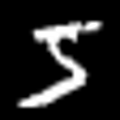

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [5]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [7]:
# lets get only the images
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [17]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs
# https://pytorch.org/docs/stable/
#########################################################################
mu = torch.mean(ims_train)
std = torch.std(ims_train)

We normalize the data as below.

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [19]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [20]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(
    dataset=ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)
dl_test = DataLoader(
    dataset=ds_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [21]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [52]:
#########################################################################
# TODO: Implement the __init__ of the MLP class.
# insert the activation after every linear layer. Important: the number of
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = []

        ##### implement this part #####
        for i in range(nLayer):
          if i==0:
            layers.append(
                nn.Linear(in_features=nInput, out_features=nHidden)
            )
            layers.append(
                act_fn
            )
          elif 0<i<nLayer-1:
            layers.append(
                nn.Linear(in_features=nHidden, out_features=nHidden)
            )
            layers.append(
                act_fn
            )
          else:
            layers.append(
                nn.Linear(in_features=nHidden, out_features=nOutput)
            )
            # layers.append(
            #     nn.Softmax()
            # )

        ###############################

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [45]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [46]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [47]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [48]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)

        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()

        ##### implement this part #####
        output = model(data)
        loss = F.cross_entropy(
            input=output,
            target=target,
        )
        loss.backward()
        optimizer.step()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [49]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [50]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311326
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.630181
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.453992
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.336242
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.546914
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.333300
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.501674
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.273225
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.359314
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.200094

Train set: Average loss: 0.2444, Accuracy: 52920/60000 (88.2%)


Test set: Average loss: 0.2672, Accuracy: 9218/10000 (92.180%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.109773
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.300887
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.220660
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.387522
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.344850
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.122337
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.165927
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [53]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 2
nHidden = 64
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338171
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.653768
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.250941
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.211536
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.504797
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.309305
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.217229
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.302671
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.244037
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.113182

Train set: Average loss: 0.2693, Accuracy: 54788/60000 (91.3%)


Test set: Average loss: 0.1709, Accuracy: 9503/10000 (95.030%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.088606
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.122463
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.236485
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.144319
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.182791
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.233192
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.060977
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance.

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are:

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [84]:
from torchvision.transforms.functional import pad
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class.
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks.
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        return self.model(x)


In [55]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [56]:
optimizer = optim.Adam(cnn.parameters())

In [57]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298992
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.237985
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.127144
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.228972
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.069284
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.173807
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.088206
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.048126
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023541
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.095081

Train set: Average loss: 0.1377, Accuracy: 56448/60000 (94.1%)


Test set: Average loss: 0.0535, Accuracy: 9836/10000 (98.360%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.150483
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.034687
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.072987
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.199129
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.028158
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.004934
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.069625
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice!
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: 0.1
<br>**Explanation**: If a neural network model is randomly initialized without any training, its weights and biases are set to random values. In this scenario, the model essentially makes random predictions, and its accuracy on a 10-class classification task would be close to random chance, which is $( \frac{1}{N} )$, where $( N )$ is the number of classes.

For a 10-class classification task, the accuracy of the randomly initialized model would be approximately $( \frac{1}{10} = 0.1 )$ or 10%. This means that the model would, on average, correctly classify 10% of the samples purely by chance.


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [76]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [77]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [78]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [79]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = torch.mean(ims_train, dim=(0, 1, 2))
std = torch.std(ims_train, dim=(0, 1, 2))

In [80]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [85]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders.
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train:
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test:
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(p=0.4),  # Horizontal flip with a probability of 40%
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mu, std)  # Normalize using precomputed mean and std
])
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mu, std)  # Normalize using precomputed mean and std
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [86]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [87]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)
    scheduler.step()

RuntimeError: ignored

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [88]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things.
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), # change in_channels
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),
            nn.Flatten(),
            nn.Linear(in_features=12544, out_features=128), # change in_features
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        return self.model(x)

Let's try again

In [89]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305185
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.972704
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.964490
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.872564

Train set: Average loss: 1.7353, Accuracy: 13018/50000 (26.0%)


Test set: Average loss: 1.6729, Accuracy: 3961/10000 (39.610%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.777187
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.750554
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.709414
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.840279

Train set: Average loss: 1.7861, Accuracy: 16888/50000 (33.8%)


Test set: Average loss: 1.5351, Accuracy: 4399/10000 (43.990%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.855874
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.705381
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.600605
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.607972

Train set: Average loss: 1.7851, Accuracy: 18294/50000 (36.6%)


Test set: Average loss: 1.5028, Accuracy: 4494/10000 (44.940%)

Train Epoch: 4 [0/50000 (

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU.

It as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
print(cnn)

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion.

In [ ]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################
num_classes = 10
cnn.fc = nn.Linear(cnn.fc.in_features, num_classes)

In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %